In [5]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from fuzzy_layer import FuzzyLayer

In [6]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
fuzzy_labels = 12 #10 цифр + 2 класса на цифры с кругляшками и без
unknown_classes_ratio = 0.0 # доля неизвестных классов 
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [8]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    if (target_label == 0) or (target_label == 6) or (target_label == 8) or (target_label == 9):
        t[0][fuzzy_labels - 2] = 1
    else:
        t[0][fuzzy_labels - 1] = 1
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [9]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [10]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [11]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [12]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [13]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [14]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)

        self.fuzzy = nn.Sequential(
             FuzzyLayer.fromdimentions(latent_dim, labels_count, trainable=True)

        )
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        labels = self.fuzzy(mu)

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu)

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [15]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + loss_kl

    if is_fuzzy_loss_active:
        loss += loss_fuzzy

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [16]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,329


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

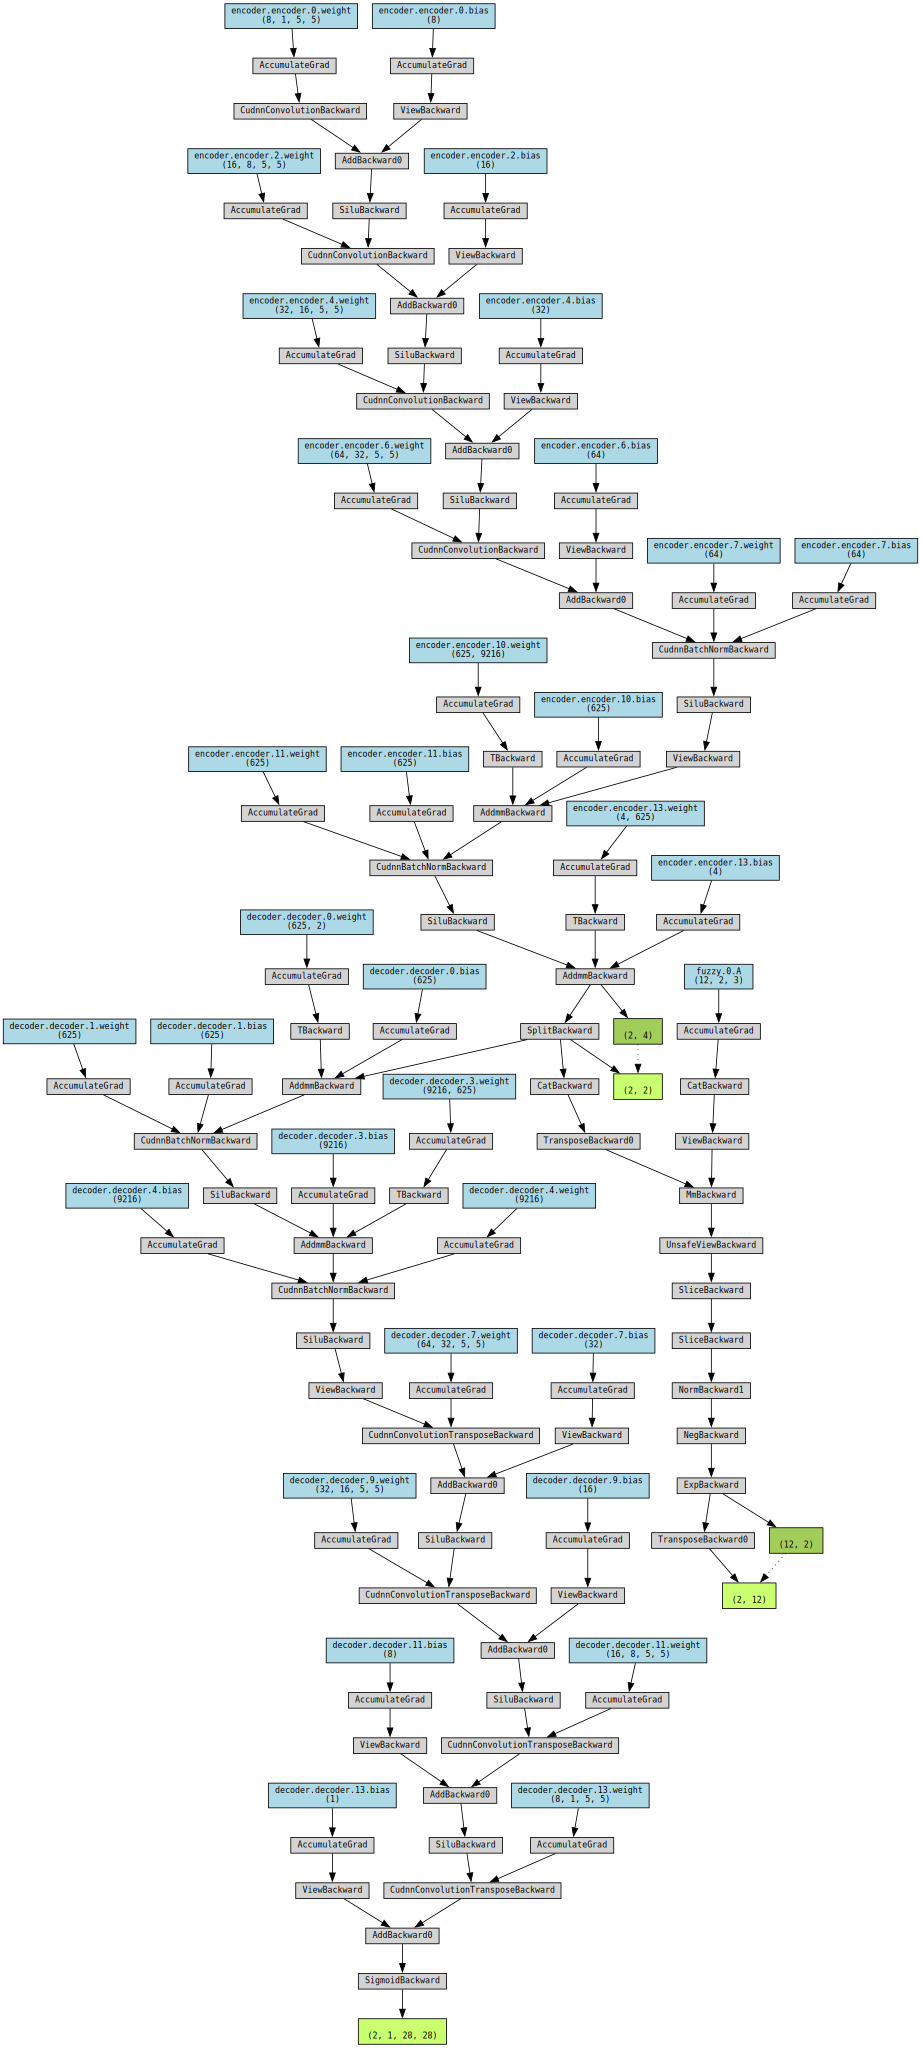

In [29]:
import torchviz
import os
os.environ["PATH"] += os.pathsep + 'F:/Users/Yuri/Downloads/windows_10_msbuild_Release_graphviz-7.0.4-win32/Graphviz/bin'


x = torch.randn(2, 1, 28, 28).to(device)
torchviz.make_dot(model(x), params=dict(model.named_parameters()))

In [45]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [46]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [47]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [48]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 20.1706 (Recon: 17.9419, KL: 0.1758 Fuzzy: 2.0529) Grad: 13.7765
Step 100 (N samples: 25,600), Loss: 8.8911 (Recon: 7.3126, KL: 0.3896 Fuzzy: 1.1888) Grad: 4.2196
Step 200 (N samples: 51,200), Loss: 8.2124 (Recon: 6.5742, KL: 0.6878 Fuzzy: 0.9504) Grad: 3.5141


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.2873 (BCE: 6.4706, KLD: 0.8991 Fuzzy: 0.9177 Accuracy 0.5651)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 8.2186 (Recon: 6.6694, KL: 0.6389 Fuzzy: 0.9103) Grad: 3.4113
Step 400 (N samples: 102,400), Loss: 8.0290 (Recon: 6.5384, KL: 0.7540 Fuzzy: 0.7367) Grad: 2.8973


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.9511 (BCE: 6.3838, KLD: 0.8369 Fuzzy: 0.7305 Accuracy 0.7105)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.7741 (Recon: 6.3116, KL: 0.7983 Fuzzy: 0.6642) Grad: 3.0152
Step 600 (N samples: 153,600), Loss: 7.8810 (Recon: 6.4440, KL: 0.7804 Fuzzy: 0.6566) Grad: 2.8799
Step 700 (N samples: 179,200), Loss: 7.8964 (Recon: 6.4667, KL: 0.8128 Fuzzy: 0.6169) Grad: 2.4284


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7898 (BCE: 6.3701, KLD: 0.8405 Fuzzy: 0.5792 Accuracy 0.8284)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.6548 (Recon: 6.2951, KL: 0.8131 Fuzzy: 0.5465) Grad: 2.4329
Step 900 (N samples: 230,400), Loss: 7.6564 (Recon: 6.3047, KL: 0.8041 Fuzzy: 0.5477) Grad: 2.9995


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7367 (BCE: 6.3921, KLD: 0.7907 Fuzzy: 0.5539 Accuracy 0.8387)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.6192 (Recon: 6.3113, KL: 0.7934 Fuzzy: 0.5145) Grad: 3.3123
Step 1,100 (N samples: 281,600), Loss: 7.7493 (Recon: 6.4589, KL: 0.7707 Fuzzy: 0.5196) Grad: 3.3169


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6773 (BCE: 6.3633, KLD: 0.8141 Fuzzy: 0.4999 Accuracy 0.8911)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.6478 (Recon: 6.3934, KL: 0.8100 Fuzzy: 0.4445) Grad: 2.5862
Step 1,300 (N samples: 332,800), Loss: 7.6206 (Recon: 6.3484, KL: 0.8210 Fuzzy: 0.4512) Grad: 3.8174
Step 1,400 (N samples: 358,400), Loss: 7.9118 (Recon: 6.6083, KL: 0.8258 Fuzzy: 0.4776) Grad: 3.1993


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5485 (BCE: 6.3482, KLD: 0.7956 Fuzzy: 0.4047 Accuracy 0.9374)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.7020 (Recon: 6.4190, KL: 0.8465 Fuzzy: 0.4365) Grad: 3.3305
Step 1,600 (N samples: 409,600), Loss: 7.5322 (Recon: 6.2811, KL: 0.8352 Fuzzy: 0.4159) Grad: 3.7990


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5313 (BCE: 6.2542, KLD: 0.8880 Fuzzy: 0.3891 Accuracy 0.9495)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.4820 (Recon: 6.2649, KL: 0.8443 Fuzzy: 0.3728) Grad: 2.4274
Step 1,800 (N samples: 460,800), Loss: 7.6245 (Recon: 6.4216, KL: 0.8387 Fuzzy: 0.3643) Grad: 2.2541


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5312 (BCE: 6.3270, KLD: 0.8262 Fuzzy: 0.3780 Accuracy 0.9462)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.2726 (Recon: 6.0479, KL: 0.8486 Fuzzy: 0.3761) Grad: 3.0576
Step 2,000 (N samples: 512,000), Loss: 7.5801 (Recon: 6.3225, KL: 0.9105 Fuzzy: 0.3472) Grad: 2.5237
Step 2,100 (N samples: 537,600), Loss: 7.5527 (Recon: 6.3426, KL: 0.9014 Fuzzy: 0.3088) Grad: 2.8651


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4446 (BCE: 6.2319, KLD: 0.8684 Fuzzy: 0.3443 Accuracy 0.9567)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.5468 (Recon: 6.2217, KL: 0.9095 Fuzzy: 0.4157) Grad: 2.9828
Step 2,300 (N samples: 588,800), Loss: 7.4966 (Recon: 6.2535, KL: 0.8967 Fuzzy: 0.3465) Grad: 2.3485


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4460 (BCE: 6.2311, KLD: 0.9010 Fuzzy: 0.3139 Accuracy 0.9587)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.4501 (Recon: 6.2456, KL: 0.8880 Fuzzy: 0.3165) Grad: 2.1255
Step 2,500 (N samples: 640,000), Loss: 7.4038 (Recon: 6.1790, KL: 0.8808 Fuzzy: 0.3440) Grad: 3.2949


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4213 (BCE: 6.2107, KLD: 0.8857 Fuzzy: 0.3249 Accuracy 0.9609)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.3980 (Recon: 6.1679, KL: 0.9067 Fuzzy: 0.3234) Grad: 2.7536
Step 2,700 (N samples: 691,200), Loss: 7.5196 (Recon: 6.2819, KL: 0.8787 Fuzzy: 0.3591) Grad: 2.7716
Step 2,800 (N samples: 716,800), Loss: 7.5978 (Recon: 6.2907, KL: 0.9561 Fuzzy: 0.3510) Grad: 2.3514


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4131 (BCE: 6.2126, KLD: 0.8977 Fuzzy: 0.3028 Accuracy 0.9606)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.6600 (Recon: 6.4148, KL: 0.9265 Fuzzy: 0.3187) Grad: 2.7938
Step 3,000 (N samples: 768,000), Loss: 7.4291 (Recon: 6.2016, KL: 0.9230 Fuzzy: 0.3044) Grad: 2.2647


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4083 (BCE: 6.1364, KLD: 0.9574 Fuzzy: 0.3146 Accuracy 0.9592)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.5097 (Recon: 6.1998, KL: 0.9908 Fuzzy: 0.3191) Grad: 2.6727
Step 3,200 (N samples: 819,200), Loss: 7.6135 (Recon: 6.3572, KL: 0.9552 Fuzzy: 0.3012) Grad: 2.5131


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3632 (BCE: 6.1261, KLD: 0.9427 Fuzzy: 0.2944 Accuracy 0.9649)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.3427 (Recon: 6.1389, KL: 0.8699 Fuzzy: 0.3340) Grad: 3.3807
Step 3,400 (N samples: 870,400), Loss: 7.4677 (Recon: 6.2297, KL: 0.9250 Fuzzy: 0.3130) Grad: 2.0980
Step 3,500 (N samples: 896,000), Loss: 7.4776 (Recon: 6.2479, KL: 0.9118 Fuzzy: 0.3179) Grad: 3.2137


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3835 (BCE: 6.1641, KLD: 0.9287 Fuzzy: 0.2908 Accuracy 0.9670)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.4267 (Recon: 6.2130, KL: 0.9305 Fuzzy: 0.2832) Grad: 2.2151
Step 3,700 (N samples: 947,200), Loss: 7.5067 (Recon: 6.1949, KL: 0.9605 Fuzzy: 0.3512) Grad: 2.1498


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3974 (BCE: 6.2069, KLD: 0.9055 Fuzzy: 0.2851 Accuracy 0.9671)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.4152 (Recon: 6.1914, KL: 0.9339 Fuzzy: 0.2898) Grad: 2.6019
Step 3,900 (N samples: 998,400), Loss: 7.4067 (Recon: 6.1121, KL: 0.9633 Fuzzy: 0.3314) Grad: 2.6875


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3711 (BCE: 6.1461, KLD: 0.9430 Fuzzy: 0.2820 Accuracy 0.9677)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.8138 (Recon: 6.5058, KL: 0.9896 Fuzzy: 0.3185) Grad: 3.0970
Step 4,100 (N samples: 1,049,600), Loss: 7.5436 (Recon: 6.2883, KL: 0.9359 Fuzzy: 0.3194) Grad: 2.3266
Step 4,200 (N samples: 1,075,200), Loss: 7.2809 (Recon: 6.0557, KL: 0.9276 Fuzzy: 0.2976) Grad: 2.5113


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3816 (BCE: 6.1817, KLD: 0.9295 Fuzzy: 0.2704 Accuracy 0.9687)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.2718 (Recon: 6.0713, KL: 0.9139 Fuzzy: 0.2866) Grad: 2.4552
Step 4,400 (N samples: 1,126,400), Loss: 7.4865 (Recon: 6.2325, KL: 0.9421 Fuzzy: 0.3119) Grad: 2.3914


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3457 (BCE: 6.1280, KLD: 0.9500 Fuzzy: 0.2677 Accuracy 0.9693)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.4869 (Recon: 6.2700, KL: 0.9243 Fuzzy: 0.2926) Grad: 2.5639
Step 4,600 (N samples: 1,177,600), Loss: 7.3903 (Recon: 6.1232, KL: 0.9427 Fuzzy: 0.3243) Grad: 2.5216


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3254 (BCE: 6.1127, KLD: 0.9486 Fuzzy: 0.2641 Accuracy 0.9708)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.5739 (Recon: 6.3296, KL: 0.9432 Fuzzy: 0.3011) Grad: 2.1595
Step 4,800 (N samples: 1,228,800), Loss: 7.4857 (Recon: 6.2678, KL: 0.9335 Fuzzy: 0.2844) Grad: 2.0198
Step 4,900 (N samples: 1,254,400), Loss: 7.3108 (Recon: 6.0527, KL: 0.9908 Fuzzy: 0.2673) Grad: 1.9726


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3289 (BCE: 6.1224, KLD: 0.9375 Fuzzy: 0.2690 Accuracy 0.9695)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.4386 (Recon: 6.1959, KL: 0.9699 Fuzzy: 0.2728) Grad: 1.7973
Step 5,100 (N samples: 1,305,600), Loss: 7.3366 (Recon: 6.0884, KL: 0.9719 Fuzzy: 0.2764) Grad: 1.5880


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3261 (BCE: 6.1077, KLD: 0.9526 Fuzzy: 0.2658 Accuracy 0.9723)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.3333 (Recon: 6.1168, KL: 0.9401 Fuzzy: 0.2764) Grad: 2.0571
Step 5,300 (N samples: 1,356,800), Loss: 7.3908 (Recon: 6.1719, KL: 0.9578 Fuzzy: 0.2612) Grad: 2.2853
Step 5,400 (N samples: 1,382,400), Loss: 7.5016 (Recon: 6.2195, KL: 0.9577 Fuzzy: 0.3243) Grad: 2.3395


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3309 (BCE: 6.1168, KLD: 0.9540 Fuzzy: 0.2601 Accuracy 0.9704)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 7.5008 (Recon: 6.2997, KL: 0.9366 Fuzzy: 0.2646) Grad: 1.5207
Step 5,600 (N samples: 1,433,600), Loss: 7.4027 (Recon: 6.1749, KL: 0.9621 Fuzzy: 0.2657) Grad: 1.6952


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3267 (BCE: 6.1145, KLD: 0.9543 Fuzzy: 0.2578 Accuracy 0.9730)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.5951 (Recon: 6.3263, KL: 0.9535 Fuzzy: 0.3153) Grad: 2.1536
Step 5,800 (N samples: 1,484,800), Loss: 7.4371 (Recon: 6.1709, KL: 0.9806 Fuzzy: 0.2857) Grad: 1.6904


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3442 (BCE: 6.1326, KLD: 0.9382 Fuzzy: 0.2734 Accuracy 0.9700)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.4110 (Recon: 6.1602, KL: 0.9632 Fuzzy: 0.2876) Grad: 2.3867
Step 6,000 (N samples: 1,536,000), Loss: 7.0649 (Recon: 5.8647, KL: 0.9538 Fuzzy: 0.2464) Grad: 2.0921
Step 6,100 (N samples: 1,561,600), Loss: 7.5064 (Recon: 6.2659, KL: 0.9921 Fuzzy: 0.2483) Grad: 2.1922


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3401 (BCE: 6.1250, KLD: 0.9440 Fuzzy: 0.2711 Accuracy 0.9723)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.6249 (Recon: 6.2875, KL: 1.0016 Fuzzy: 0.3358) Grad: 3.1282
Step 6,300 (N samples: 1,612,800), Loss: 7.7421 (Recon: 6.3820, KL: 0.9910 Fuzzy: 0.3691) Grad: 3.7105


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3184 (BCE: 6.0979, KLD: 0.9657 Fuzzy: 0.2547 Accuracy 0.9717)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.3509 (Recon: 6.0480, KL: 0.9951 Fuzzy: 0.3079) Grad: 2.7875
Step 6,500 (N samples: 1,664,000), Loss: 7.2305 (Recon: 5.9608, KL: 1.0032 Fuzzy: 0.2665) Grad: 2.2138


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3278 (BCE: 6.1049, KLD: 0.9731 Fuzzy: 0.2498 Accuracy 0.9719)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.4342 (Recon: 6.1892, KL: 0.9852 Fuzzy: 0.2597) Grad: 2.0617
Step 6,700 (N samples: 1,715,200), Loss: 7.1481 (Recon: 5.8529, KL: 0.9986 Fuzzy: 0.2966) Grad: 2.2267
Step 6,800 (N samples: 1,740,800), Loss: 7.2985 (Recon: 6.0353, KL: 0.9771 Fuzzy: 0.2862) Grad: 2.2457


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3044 (BCE: 6.0701, KLD: 0.9732 Fuzzy: 0.2611 Accuracy 0.9720)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.3549 (Recon: 6.1375, KL: 0.9820 Fuzzy: 0.2354) Grad: 1.3654
Step 7,000 (N samples: 1,792,000), Loss: 7.2587 (Recon: 5.9805, KL: 1.0151 Fuzzy: 0.2631) Grad: 2.3490


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2792 (BCE: 6.0330, KLD: 0.9915 Fuzzy: 0.2547 Accuracy 0.9720)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.2570 (Recon: 5.9846, KL: 1.0157 Fuzzy: 0.2566) Grad: 2.0524
Step 7,200 (N samples: 1,843,200), Loss: 7.3726 (Recon: 6.1022, KL: 0.9996 Fuzzy: 0.2708) Grad: 2.2763


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2990 (BCE: 6.0449, KLD: 1.0027 Fuzzy: 0.2514 Accuracy 0.9718)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.3315 (Recon: 6.0074, KL: 1.0313 Fuzzy: 0.2928) Grad: 2.8448
Step 7,400 (N samples: 1,894,400), Loss: 7.6537 (Recon: 6.3630, KL: 1.0017 Fuzzy: 0.2890) Grad: 2.4493
Step 7,500 (N samples: 1,920,000), Loss: 7.3163 (Recon: 6.0328, KL: 0.9952 Fuzzy: 0.2882) Grad: 2.0484


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2860 (BCE: 6.0620, KLD: 0.9765 Fuzzy: 0.2474 Accuracy 0.9727)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.4494 (Recon: 6.1642, KL: 1.0172 Fuzzy: 0.2680) Grad: 1.7870
Step 7,700 (N samples: 1,971,200), Loss: 7.4284 (Recon: 6.1762, KL: 1.0133 Fuzzy: 0.2389) Grad: 1.8766


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2826 (BCE: 6.0184, KLD: 1.0087 Fuzzy: 0.2554 Accuracy 0.9721)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 7.3218 (Recon: 6.0515, KL: 0.9778 Fuzzy: 0.2925) Grad: 1.8746
Step 7,900 (N samples: 2,022,400), Loss: 7.4994 (Recon: 6.2324, KL: 1.0091 Fuzzy: 0.2580) Grad: 1.8505


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2904 (BCE: 6.0078, KLD: 1.0326 Fuzzy: 0.2501 Accuracy 0.9735)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 7.3450 (Recon: 6.0976, KL: 0.9895 Fuzzy: 0.2579) Grad: 1.9938
Step 8,100 (N samples: 2,073,600), Loss: 7.1615 (Recon: 5.8791, KL: 1.0242 Fuzzy: 0.2582) Grad: 2.4243
Step 8,200 (N samples: 2,099,200), Loss: 7.0604 (Recon: 5.7816, KL: 1.0189 Fuzzy: 0.2600) Grad: 1.2956


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2897 (BCE: 6.0270, KLD: 1.0119 Fuzzy: 0.2508 Accuracy 0.9744)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 7.2897 (Recon: 6.0208, KL: 1.0001 Fuzzy: 0.2688) Grad: 2.2198
Step 8,400 (N samples: 2,150,400), Loss: 7.6875 (Recon: 6.2697, KL: 1.0570 Fuzzy: 0.3607) Grad: 3.4183


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2723 (BCE: 6.0023, KLD: 1.0244 Fuzzy: 0.2457 Accuracy 0.9732)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.4695 (Recon: 6.1534, KL: 1.0189 Fuzzy: 0.2972) Grad: 2.8954
Step 8,600 (N samples: 2,201,600), Loss: 7.3734 (Recon: 6.1238, KL: 1.0132 Fuzzy: 0.2364) Grad: 1.7265


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3243 (BCE: 6.0191, KLD: 1.0370 Fuzzy: 0.2682 Accuracy 0.9732)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.4760 (Recon: 6.2009, KL: 1.0180 Fuzzy: 0.2571) Grad: 2.2004
Step 8,800 (N samples: 2,252,800), Loss: 7.3369 (Recon: 6.0698, KL: 1.0025 Fuzzy: 0.2647) Grad: 1.9752
Step 8,900 (N samples: 2,278,400), Loss: 7.3243 (Recon: 6.0289, KL: 1.0202 Fuzzy: 0.2751) Grad: 2.3372


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2812 (BCE: 5.9883, KLD: 1.0327 Fuzzy: 0.2602 Accuracy 0.9744)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 7.3007 (Recon: 6.0076, KL: 1.0486 Fuzzy: 0.2445) Grad: 2.2135
Step 9,100 (N samples: 2,329,600), Loss: 7.3499 (Recon: 6.0216, KL: 1.0668 Fuzzy: 0.2615) Grad: 1.8083


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2854 (BCE: 6.0123, KLD: 1.0270 Fuzzy: 0.2460 Accuracy 0.9754)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 7.2959 (Recon: 5.9985, KL: 1.0460 Fuzzy: 0.2514) Grad: 2.0925
Step 9,300 (N samples: 2,380,800), Loss: 7.5747 (Recon: 6.2293, KL: 1.0417 Fuzzy: 0.3037) Grad: 2.8367


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2734 (BCE: 5.9998, KLD: 1.0324 Fuzzy: 0.2412 Accuracy 0.9748)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 7.5163 (Recon: 6.1627, KL: 1.0541 Fuzzy: 0.2995) Grad: 2.8540
Step 9,500 (N samples: 2,432,000), Loss: 7.3856 (Recon: 6.0841, KL: 1.0476 Fuzzy: 0.2539) Grad: 2.0883
Step 9,600 (N samples: 2,457,600), Loss: 7.3402 (Recon: 6.0693, KL: 1.0258 Fuzzy: 0.2452) Grad: 2.1225


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2922 (BCE: 6.0092, KLD: 1.0350 Fuzzy: 0.2480 Accuracy 0.9751)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.6023 (Recon: 6.2652, KL: 1.0716 Fuzzy: 0.2654) Grad: 1.6361
Step 9,800 (N samples: 2,508,800), Loss: 7.1519 (Recon: 5.8805, KL: 1.0451 Fuzzy: 0.2263) Grad: 1.5559


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2731 (BCE: 5.9883, KLD: 1.0399 Fuzzy: 0.2449 Accuracy 0.9734)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.1968 (Recon: 5.9047, KL: 1.0584 Fuzzy: 0.2338) Grad: 1.6685
Step 10,000 (N samples: 2,560,000), Loss: 7.3059 (Recon: 5.9687, KL: 1.0582 Fuzzy: 0.2790) Grad: 2.5357
Step 10,100 (N samples: 2,585,600), Loss: 7.4346 (Recon: 6.1318, KL: 1.0095 Fuzzy: 0.2933) Grad: 2.3564


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2839 (BCE: 6.0118, KLD: 1.0189 Fuzzy: 0.2531 Accuracy 0.9745)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.3479 (Recon: 6.0226, KL: 1.0465 Fuzzy: 0.2788) Grad: 2.2451
Step 10,300 (N samples: 2,636,800), Loss: 7.4896 (Recon: 6.1939, KL: 1.0510 Fuzzy: 0.2447) Grad: 1.9374


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2896 (BCE: 6.0115, KLD: 1.0321 Fuzzy: 0.2460 Accuracy 0.9756)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 7.1635 (Recon: 5.8782, KL: 1.0649 Fuzzy: 0.2204) Grad: 1.8639
Step 10,500 (N samples: 2,688,000), Loss: 7.3359 (Recon: 5.9267, KL: 1.0796 Fuzzy: 0.3295) Grad: 2.9553


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2597 (BCE: 5.9618, KLD: 1.0613 Fuzzy: 0.2367 Accuracy 0.9751)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 7.2557 (Recon: 5.9568, KL: 1.0501 Fuzzy: 0.2488) Grad: 1.4857
Step 10,700 (N samples: 2,739,200), Loss: 7.3649 (Recon: 6.0905, KL: 1.0206 Fuzzy: 0.2539) Grad: 2.0735
Step 10,800 (N samples: 2,764,800), Loss: 7.2325 (Recon: 5.9006, KL: 1.0970 Fuzzy: 0.2348) Grad: 1.5583


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2923 (BCE: 6.0243, KLD: 1.0198 Fuzzy: 0.2483 Accuracy 0.9750)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.4123 (Recon: 6.0771, KL: 1.0348 Fuzzy: 0.3004) Grad: 2.2003
Step 11,000 (N samples: 2,816,000), Loss: 7.2851 (Recon: 5.9736, KL: 1.0595 Fuzzy: 0.2519) Grad: 1.6600


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2783 (BCE: 5.9975, KLD: 1.0382 Fuzzy: 0.2426 Accuracy 0.9754)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 7.3403 (Recon: 6.0450, KL: 1.0793 Fuzzy: 0.2160) Grad: 2.3146
Step 11,200 (N samples: 2,867,200), Loss: 7.3944 (Recon: 6.0381, KL: 1.0627 Fuzzy: 0.2935) Grad: 2.2782


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2666 (BCE: 5.9833, KLD: 1.0433 Fuzzy: 0.2399 Accuracy 0.9756)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.2631 (Recon: 5.9586, KL: 1.0415 Fuzzy: 0.2630) Grad: 1.9870
Step 11,400 (N samples: 2,918,400), Loss: 7.4321 (Recon: 6.1523, KL: 1.0466 Fuzzy: 0.2331) Grad: 1.9308
Step 11,500 (N samples: 2,944,000), Loss: 7.4739 (Recon: 6.1833, KL: 1.0442 Fuzzy: 0.2463) Grad: 2.5428


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2602 (BCE: 5.9656, KLD: 1.0563 Fuzzy: 0.2383 Accuracy 0.9755)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 7.3975 (Recon: 6.0506, KL: 1.0800 Fuzzy: 0.2668) Grad: 3.1544
Step 11,700 (N samples: 2,995,200), Loss: 7.4858 (Recon: 6.1858, KL: 1.0389 Fuzzy: 0.2611) Grad: 1.5114


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2719 (BCE: 6.0005, KLD: 1.0258 Fuzzy: 0.2457 Accuracy 0.9757)


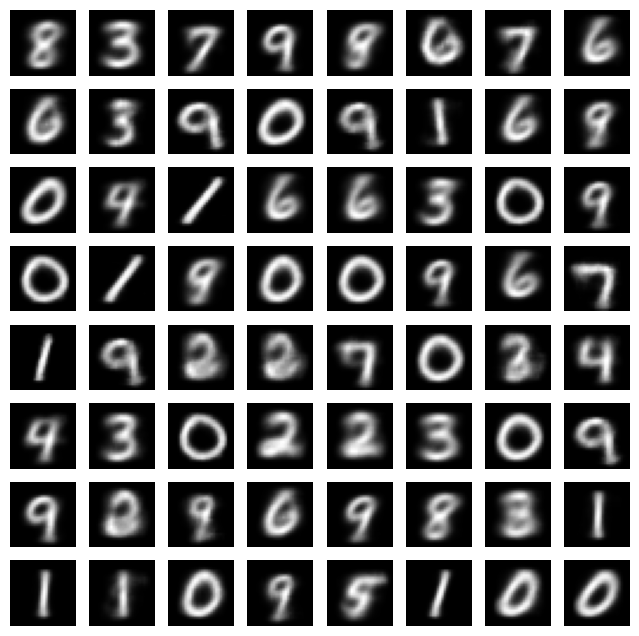

In [49]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [50]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
pred_circ_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_circ_all.append(np.argmax(labels[:, (fuzzy_labels-2):].cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [51]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)
pred_circ_all = np.concatenate(pred_circ_all, axis=0)

In [52]:
np.sum(y_all==pred_y_all)/len(y_all)

0.9751

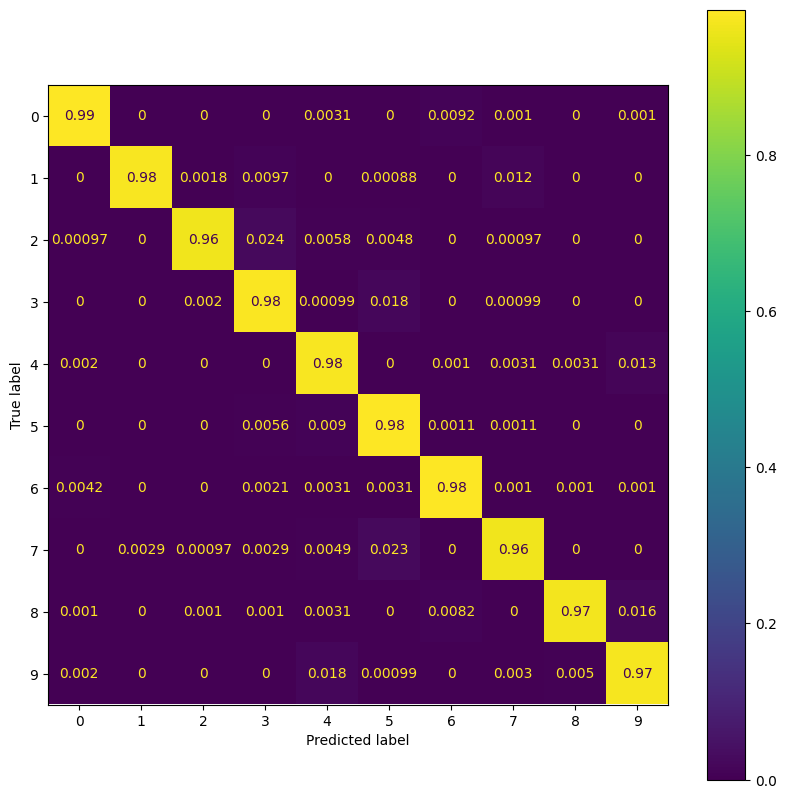

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

Text(0, 0.5, 'cvae 2')

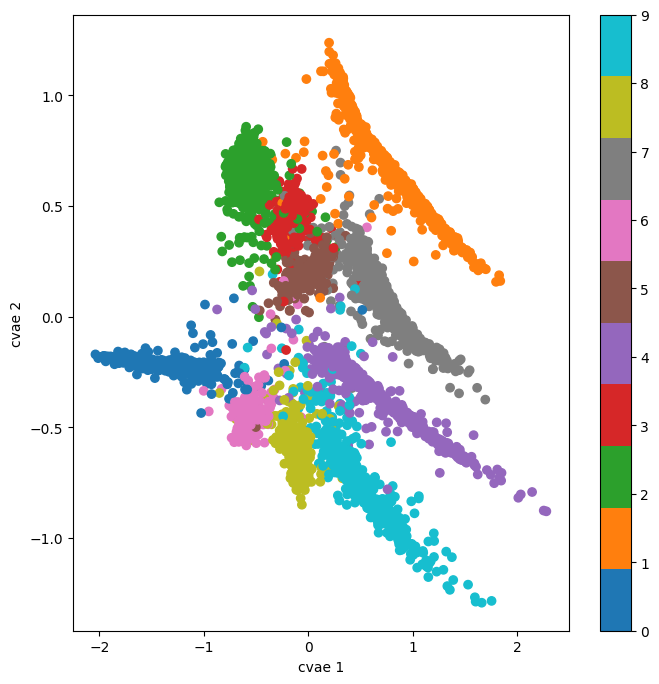

In [59]:
plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")
# plt.show()
#plt.savefig('habr/mnist_2d_scatter_origin_labels_cvae.webp')

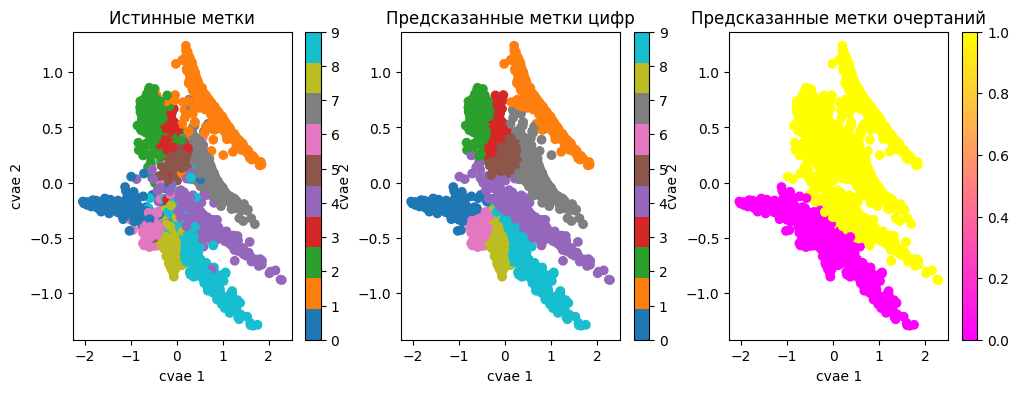

In [56]:
figure, axis = plt.subplots(1, 3, figsize=(12, 4)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
axis[0].set_title("Истинные метки")
axis[0].set_xlabel("cvae 1")
axis[0].set_ylabel("cvae 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
axis[1].set_title("Предсказанные метки цифр") 
axis[1].set_xlabel("cvae 1")
axis[1].set_ylabel("cvae 2")
sc3 = axis[2].scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='spring')
axis[2].set_title("Предсказанные метки очертаний") 
axis[2].set_xlabel("cvae 1")
axis[2].set_ylabel("cvae 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
figure.colorbar(sc3)
plt.show()

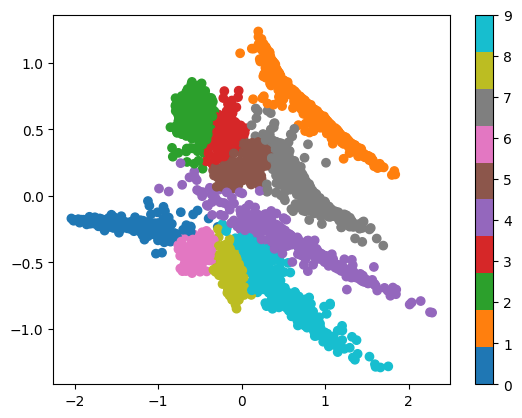

In [57]:

plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_labels.webp')

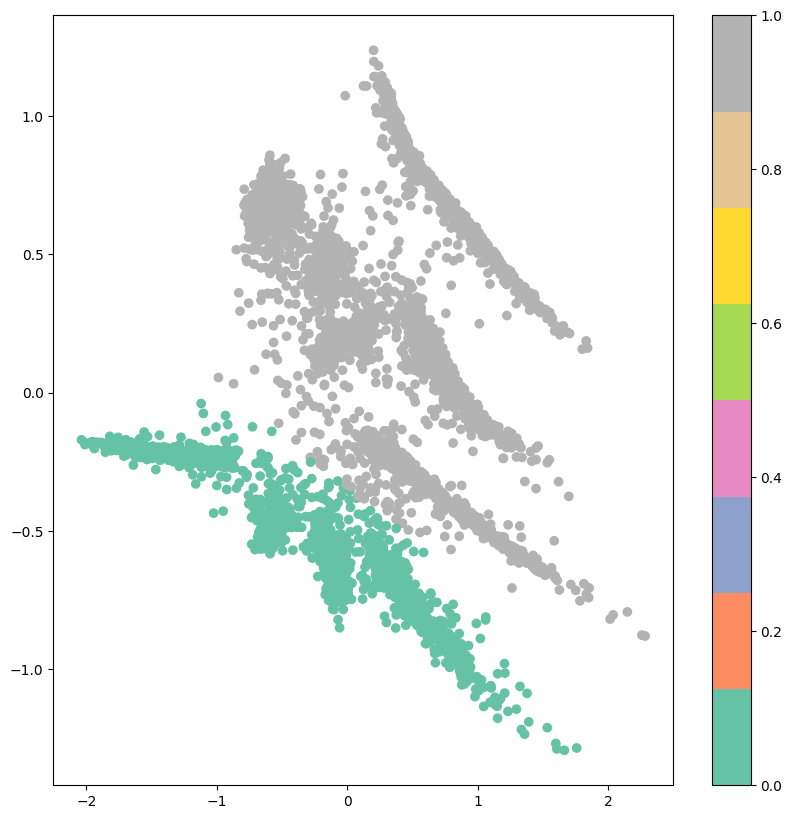

In [60]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='Set2')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_circles.webp')

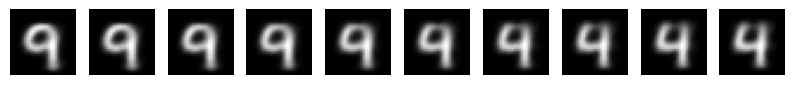

In [71]:
n = 10
z2 = torch.linspace(-1, -0.5, n)
z1 = torch.zeros_like(z2) + 1

z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('cvae_mnist_interp.webp')